# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from feature_engineering import *
from implementations import *
from cross_validation import *

# Load data

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../dataset", sub_sample=False)

In [3]:
# Change the predictions from {-1, 1} to {0, 1}
y_train = (y_train + 1) / 2

# Handle missing data and feature selection

In [4]:
# Delete first features which are useless for the model
x_train = np.delete(x_train, np.arange(26), 1)
x_test = np.delete(x_test, np.arange(26), 1)

In [5]:
# Delete features with more than 50% of missing values
threshold = 0.5

# The percentage of NaN values in each column
nan_percentage = np.sum(np.isnan(x_train), axis=0) / x_train.shape[0]

# Get the indices of columns where NaN percentage is below or equal to the threshold
columns_to_keep = np.where(nan_percentage <= threshold)[0]

# Create a new array with the selected columns
x_train = x_train[:, columns_to_keep]
x_test = x_test[:, columns_to_keep]

NaN are here replaced with the median. We also tried to replace them with a high number in categorical features to then separate them through one hot encoding from the real informations. This last method didn't improve our model.

In [6]:
# Calculate the median of each column while ignoring NaN values
median_values_tr = np.nanmedian(x_train, axis=0)
median_values_te = np.nanmedian(x_test, axis=0)

# Create a boolean mask to identify NaN values in the dataset
nan_mask_tr = np.isnan(x_train)
nan_mask_te = np.isnan(x_test)

# Replace NaN values with the corresponding column medians
x_train[nan_mask_tr] = np.take(median_values_tr, np.where(nan_mask_tr)[1])
x_test[nan_mask_te] = np.take(median_values_te, np.where(nan_mask_te)[1])

In [7]:
# Indices of the 35 most correlated features
most_corr_feat = best_features(x_train, y_train, 35)
print("Indices of the 35 most correlated features: ", most_corr_feat)

Indices of the 35 most correlated features:  [  0  89  87  28  90   8  72  88  71  73  79  20  35  38  11  75  17  29
  34  31  12  58   1  97  27 154  16  43   3  23  67  60  98  41  21]


The features 87, 88, 89 and 90 are very correlated since they all represent the distribution of age. 89 is numerical and thus more precise in this case, so we keep only this one to avoid redundancy. Features 1, 3, 29 and 43 have both numerical and categorical aspects. We cleaned them by separating these two parts, but adding them to the train data didn't improve the model. Since the cleaning took some time to run we decided to not use them.

In [8]:
# Indices of the categorical features among the 35 best features
cat_feat_idx = [0,75,28,8,71,73,20,38,11,12,58,16,97,72,79,35,31,17,34,154,27,23,21,41,67,60,98]

# Indices of the numerical features among the 35 best features
num_feat_idx = [89]

# Categorical features encoded
x_train_cat = categorical_features_processing(x_train, cat_feat_idx)
x_test_cat = categorical_features_processing(x_test, cat_feat_idx)

# Concatenate categorical and numerical features
x_train_processed = np.hstack((x_train_cat, x_train[:, num_feat_idx[0]].reshape(-1,1)))
x_test_processed = np.hstack((x_test_cat, x_test[:, num_feat_idx[0]].reshape(-1,1)))

# Standardize the data
x_train_processed = standardize(x_train_processed)
x_test_processed = standardize(x_test_processed)

# PCA
x_train_PCA, x_test_PCA = PCA(x_train_processed, x_test_processed, 115)

# Model

## Hyper-parameters tuning

We tested different values, here we test only 3 of them as an example. This can take some time to run.

In [ ]:
# Values of lambda to test
lambdas = [1e-7, 1e-8, 1e-9]

# Values of gamma to test
gammas = [0.01, 0.1, 1.0]

best_gamma, best_lambda, best_f1 = hyper_param_tuning(y_train, x_train_PCA, 5, gammas, lambdas)
print("Best gamma: ", best_gamma)
print("Best lambda: ", best_lambda)
print("Best F1 score: ", best_f1)

## Fit

In [9]:
x_tr, x_val, y_tr, y_val = split_data(x_train_PCA, y_train, 0.8)

tx_tr = np.c_[np.ones((y_tr.shape[0], 1)), x_tr]
tx_val = np.c_[np.ones((y_val.shape[0], 1)), x_val]
initial_w = np.zeros(tx_tr.shape[1])

losses, scores, val_losses, val_scores, best_w, best_f1 = weighted_reg_logistic_regression_demo(y_tr, tx_tr, tx_val, y_val, initial_w, 201, 1e-7, 1.0)

The higher F1 score on the validation se is reached after 162 iterations, and is equal to 0.4102079395085066


Text(0.5, 0, 'Iteration')

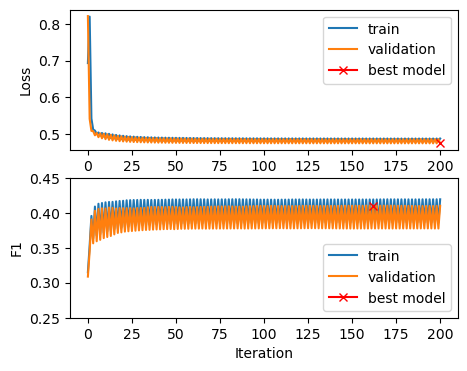

In [10]:
print('The higher F1 score on the validation se is reached after', np.argmax(val_scores), 'iterations, and is equal to', max(val_scores))

fig, axes = plt.subplots(2,1, figsize=(5,4))

axes[0].plot(losses, label="train")
axes[0].plot(val_losses, label="validation")
axes[0].plot(np.argmin(val_losses),
        np.min(val_losses),
        marker="x", color="r", label="best model")
axes[0].legend()
axes[0].set_ylabel("Loss")

axes[1].plot(scores, label="train")
axes[1].plot(val_scores, label="validation")
axes[1].plot(np.argmax(val_scores),
        np.max(val_scores),
        marker="x", color="r", label="best model")
axes[1].legend()
axes[1].set_ylim([0.25, 0.45])
axes[1].set_ylabel("F1")
axes[1].set_xlabel("Iteration")

## Predict 

In [11]:
#Use the best weights on validation to predict the test labels
tx_test = np.c_[np.ones((x_test_PCA.shape[0], 1)), x_test_PCA]

y_pred = np.dot(tx_test, best_w)
y_pred = np.where(y_pred<0.5,-1,1)

## Create submission

In [12]:
# create csv submission file
create_csv_submission(test_ids, y_pred, "../submission.csv")

# Tested models results with cross-validation

## Report accuracies and f1s

In [13]:
#Each model is runned with the respective best hyperparameters 
accuracies_mean, accuracies_std, f1s_mean, f1s_std = models_cross_validation(y_train, x_train_PCA, 4, seed=1)

print("Random, (accuracy, f1-score)", accuracies_mean[0], f1s_mean[0])
print("Logistic regression, (accuracy, f1-score)", accuracies_mean[1], f1s_mean[1])
print("Regularized logistic regression, (accuracy, f1-score)", accuracies_mean[2], f1s_mean[2])
print("Weighted regularized logistic regression, (accuracy, f1-score)", accuracies_mean[3], f1s_mean[3])

Random, (accuracy, f1-score) 0.4985981251447588 0.1495678434818157
Logistic regression, (accuracy, f1-score) 0.9139766923067547 0.15443501503513546
Regularized logistic regression, (accuracy, f1-score) 0.9139705971986885 0.15452573181235016
Weighted regularized logistic regression, (accuracy, f1-score) 0.7872258725147198 0.38304075236571383


## Plot

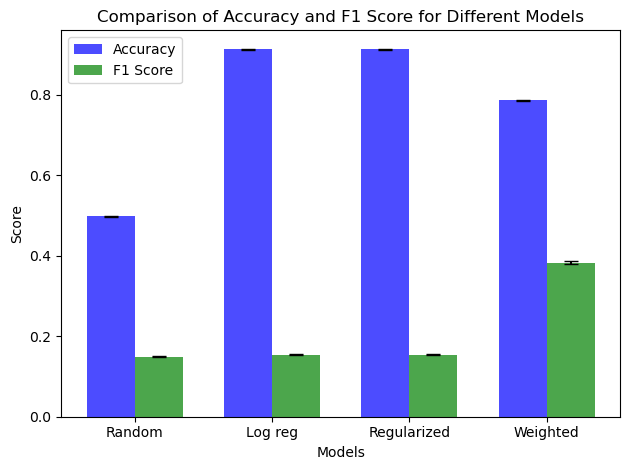

In [14]:
# Set the width of the bars
bar_width = 0.35

# Set the x-axis positions for the bars
x = np.arange(len(accuracies_mean))

# Create subplots for accuracy and F1 score with different colors
fig, ax = plt.subplots()
accuracy_bars = ax.bar(x - bar_width/2, accuracies_mean, bar_width, label='Accuracy', yerr=accuracies_std, capsize=5, color='b', alpha=0.7)
f1_score_bars = ax.bar(x + bar_width/2, f1s_mean, bar_width, label='F1 Score', yerr=f1s_std, capsize=5, color='g', alpha=0.7)

# Set x-axis labels
x_labels = ['Random', 'Log reg', 'Regularized', 'Weighted']
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Comparison of Accuracy and F1 Score for Different Models')
ax.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()